In [11]:
import matplotlib.pyplot as plt
from aerobot.io import RESULTS_PATH, load_results_dict, DATA_PATH
from aerobot.plot import plot_configure_mpl, PRETTY_NAMES
from aerobot.contigs import KMER_FEATURE_TYPES
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress
import numpy as np
import os
from typing import List, Dict, Tuple
import scipy.optimize
import glob 

%load_ext autoreload 
%autoreload 2 

plot_configure_mpl(n_colors=6) # Want at least one color for each genome have results for. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
CONTIGS_PATH = os.path.join(DATA_PATH, 'contigs')

# These are the feature types which I currently have results for. 
feature_types = ['nt_1mer', 'nt_2mer', 'nt_3mer', 'aa_1mer', 'aa_2mer', 'aa_3mer']

# SI Figure 6

This figure shows the results of applying the trained classifier to normalized contig data.

How would be best to show this... Probably want to plot one genome at a time, or perhaps multiple genomes on the same plot? And then fit a regression line through the data points. I expect the trend will be the same across correctly-predicted genomes. As a side note, it is probably best to select for genomes where the end prediction of the model was correct.

I think it is worth noting (1) how does the prediction correctness vary by genome (or the true metabolic label of the genome) and (2) how does the prediction correctness vary by contig size. 

In [18]:
def logistic(x:np.ndarray, k:float, x0:float, L:float):
    '''Logistic curve equation for fitting the data.'''
    return L / (1 + np.exp(-k * (x - x0)))

def residuals(params:np.ndarray, y:np.ndarray, x:np.ndarray):
    '''Compute residuals between least squares approximation and the true y-values.'''
    k, x0, L = params
    err = y - logistic(x, k, x0, L)
    return err

def fit_and_evaluate_logistic(x:np.ndarray, y:np.ndarray):
    '''Fit a logistic curve to the input data.'''
    params = [0.001, 0, 1] # Initial guesses for the parameters.
    lsq = scipy.optimize.least_squares(residuals, params, args=(y, x)) 
    k, x0, L = lsq.x # Get the fitted params from the least-squares result. 
    # print('k =', k)
    # print('x0 =', x0)
    # print('L =', L)
    # Compute x and y values for the fitted function. 
    x = np.linspace(min(x), max(x), 100)
    y = logistic(x, k, x0, L)
    return x, y

In [15]:
# Load the correct labels for each genome. 
genome_labels_df = pd.read_csv(os.path.join(CONTIGS_PATH, 'genomes.csv'), index_col=0)

# Organize the contigs results into DataFrames for plotting. 
contigs_results = dict() 

for feature_type in feature_types:
    predictions_df = pd.read_csv(os.path.join(RESULTS_PATH, f'predict_contigs_{feature_type}.csv')).set_index('genome_id')
    predictions_df = predictions_df.merge(genome_labels_df, how='left', left_index=True, right_index=True)
    # predictions_df['correct'] = predictions_df.prediction.values == predictions_df.label.values 

    # We want to assess contig predictions based on the whole-genome predictions. 
    whole_genome_predictions_df = predictions_df[predictions_df.contig_size == 0][['prediction']]
    whole_genome_predictions_df = whole_genome_predictions_df.rename(columns={'prediction':'whole_genome_prediction'})
    predictions_df = predictions_df.merge(whole_genome_predictions_df, how='left', left_index=True, right_index=True)

    # whole_genome_predictions_df = whole_genome_predictions_df[whole_genome_predictions_df.correct]
    predictions_df['correct'] = predictions_df.whole_genome_prediction == predictions_df.prediction
    # print(f'Model predictions based on {feature_type} were correct for {len(genome_ids)} genomes.')

    # predictions_df = predictions_df.loc[genome_ids]
    contigs_results[feature_type] = predictions_df
    
    # percent_correct_by_contig_size = predictions_df[['correct', 'contig_size']].groupby('contig_size').mean()


In [19]:
def plot_figure_6(contigs_results:Dict[str, pd.DataFrame], fig:plt.Figure=None, grids:List[GridSpec]=None):
    
    for i, feature_type in enumerate(feature_types):
        ax = fig.add_subplot(grids[i])
        ax.set_title(PRETTY_NAMES[feature_type], loc='left')

        # Extract the results for the specified feature type. 
        results = contigs_results[feature_type]
        
        labels, handles = [],[]
        # Group the results according to the true label of the genome...
        for label, label_df in results.groupby('label'):

            n_genomes = len(set(label_df.index.values))
            labels.append(f'{label} (n={n_genomes})')
            # print(f'plot_figure_6: {len(label_df)} entries for label {label}.')

            x_vals, y_vals = [], []
            for contig_size, contig_size_df in label_df.groupby('contig_size'):
                if contig_size == 0: # Skip the whole-genome prediction.
                    continue
                x_vals.append(contig_size)
                y_vals.append(contig_size_df.correct.mean())

            handles.append(ax.scatter(x_vals, y_vals, s=2))
            ax.plot(*fit_and_evaluate_logistic(x_vals, y_vals), lw=1)
            
        ax.legend(handles=handles, labels=labels)
        ax.set_xlabel('contig size')
        ax.set_ylabel('fraction matching genome prediction')
    


/tmp/ipykernel_158044/3883603187.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


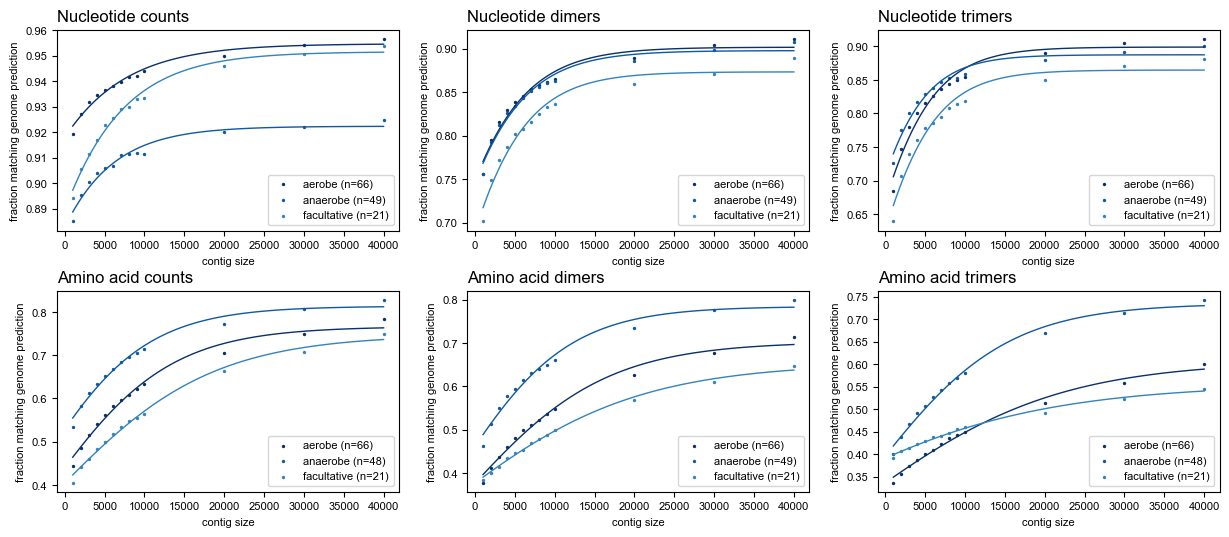

In [20]:
n_rows, n_cols = 2, 3
fig = plt.figure(figsize=(5 * n_cols, 3 * n_rows))

grids = GridSpec(n_rows, n_cols, hspace=0.3)
grids = [grids[0, i] for i in range(n_cols)] + [grids[1, i] for i in range(n_cols)]

plot_figure_6(contigs_results, fig=fig, grids=grids)

plt.tight_layout()